In [2]:

import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import jax.scipy as jsp
import jax.scipy.optimize as jsp_opt
import optax 
import jaxopt
from jaxopt import ScipyBoundedMinimize
import matplotlib.pyplot as plt
import jax

def jdprint(obj, string = ""):
    jax.debug.print(string+': {x}', x=obj)

# @jit
def mpm(E):
    # nsteps
    nsteps = 10
    

    # Domain length
    Lx = 1
    Ly = 1

    boundary_nodes = [0, 1]

    # Material properties
    rho = 1 # density
    E = E # young's modulus
    poisson_ratio = 0 # poisson ratio
    bulk_modulus = E / (3 * (1 - 2 * poisson_ratio))
    G = E / (2 * (1 + poisson_ratio))
    a1 = bulk_modulus + (4 / 3) * G
    a2 = bulk_modulus - (2 / 3) * G


    # Computational grid
    nelementsx = 1
    nelementsy = 1
    nelements = nelementsx * nelementsy
    
    dx = Lx / nelementsx
    dy = Ly / nelementsy
    
    # Create equally spaced nodes
    x_n, y_n = jnp.meshgrid(jnp.linspace(0, Lx, nelementsx + 1), jnp.linspace(0, Ly, nelementsy + 1))
    x_n = x_n.flatten()
    y_n = y_n.flatten()
    x_n_1D = jnp.linspace(0, Lx, nelementsx + 1)
    y_n_1D = jnp.linspace(0, Ly, nelementsy + 1)
    nnodes = len(x_n)
    
    # jdprint(x_n, 'xn')
    # jdprint(y_n, 'yn')
    # jdprint(x_n_1D, 'xn1d')
    # jdprint(y_n_1D, 'yn1d')
    
    # Set-up a 2D array of elements with node ids
    elements = jnp.zeros((nelements, 4), dtype=int)
    for eidx in range(nelementsx):
        for eidy in range(nelementsy):
            eid = eidx + eidy * nelementsx
            elements = elements.at[eid, 0].set(eidx + eidy * (nelementsx + 1))
            elements = elements.at[eid, 1].set(elements[eid, 0] + 1)
            elements = elements.at[eid, 2].set(elements[eid, 1] + nelementsx + 1)
            elements = elements.at[eid, 3].set(elements[eid, 0] + nelementsx + 1)

    
            
    # Loading conditions
    v0x = 0              # initial velocity
    v0y = 0              # initial velocity
    # c  = jnp.sqrt(E/rho)   # speed of sound
    b1 = jnp.pi / (2 * Lx) # beta1
    b2 = jnp.pi / (2 * Ly) # beta2
    # w1 = b1 * c            # omega1
    # w2 = b2 * c            # omega2
    
    # Create material points at the center of each element
    ppe = 4
    nparticles = ppe * nelements  # number of particles

    # Set up a 2D array of elements with particle ids
    pids = jnp.zeros((nelements, ppe), dtype=int)
    for eid in range(nelements):
        pids = pids.at[eid, :].set(jnp.arange(ppe) + eid * ppe)

    
    # Id of the particle in the central element
    pmid = nparticles// 2  # Midpoint of the material points
    
    # Material point properties
    x_p        = jnp.zeros(nparticles)                  # positions
    y_p        = jnp.zeros(nparticles)                  # positions
    vol_p      = jnp.ones(nparticles) * dx * dy / ppe   # volume
    mass_p     = vol_p * rho                            # mass
    stress_px  = jnp.zeros(nparticles)                  # stress in xx
    stress_py  = jnp.zeros(nparticles)                  # stress in yy
    stress_pxy = jnp.zeros(nparticles)                  # stress in xy
    vel_px     = jnp.zeros(nparticles)                  # velocity
    vel_py     = jnp.zeros(nparticles)                  # velocity
    # stress_p  = jnp.zeros((nparticles, 3))       # stress
    # disp_p    = jnp.zeros((nparticles, 2))       # displacement
    # vel_p     = jnp.zeros((nparticles, 2))       # velocity
    # strain_p  = jnp.zeros((nparticles, 3))       # strain

    

    # Initialize particle positions
    # need to fix this to generalize to more than 1 element
    if ppe == 1:
        x_p      = jnp.array([0.5])
        y_p      = jnp.array([0.5])
        pids     = jnp.array([[0]])
    elif ppe == 4:
        x_p      = jnp.array([0.25, 0.75, 0.25, 0.75])
        y_p      = jnp.array([0.25, 0.25, 0.75, 0.75])
        pids     = jnp.array([[0, 1, 3, 2]])
    else: raise NotImplementedError

    # set initial velocities
    vel_p   = jnp.array([v0x * jnp.sin(b1 * x_p), v0y * jnp.sin(b2 * y_p)])
    

    # Time steps and duration
    # dt_crit = jnp.max(jnp.array([dx / c, dy / c]))
    dt = 0.01
    
    # results
    # tt = jnp.zeros(nsteps)
    vt = jnp.zeros((nsteps, 2))
    xt = jnp.zeros((nsteps, 2))
    sigmat = jnp.zeros((nsteps, nparticles, 3))



    
    def step(i, carry):
        x_p, y_p, mass_p, vel_px, vel_py, vol_p, stress_px, stress_py, stress_pxy, vt, xt, sigmat = carry
        
        # jdprint(i)

        # reset nodal values
        mass_n  = jnp.zeros(nnodes)   # mass
        mom_nx   = jnp.zeros(nnodes)  # momentum
        mom_ny   = jnp.zeros(nnodes)  # momentum
        fint_nx  = jnp.zeros(nnodes)  # internal force
        fint_ny  = jnp.zeros(nnodes)  # internal force

        # iterate through each element
        for eid in range(nelements):


            # get nodal ids
            nid1, nid2, nid3, nid4 = elements[eid]

            e_pids = pids[eid]
            # iterate through each particle
            for pid in e_pids:
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                N1x = 1 - abs(x_p[pid] - x_n[nid1]) / dx
                N2x = 1 - abs(x_p[pid] - x_n[nid2]) / dx
                N3x = 1 - abs(x_p[pid] - x_n[nid3]) / dx
                N4x = 1 - abs(x_p[pid] - x_n[nid4]) / dx
                N1y = 1 - abs(y_p[pid] - y_n[nid1]) / dy
                N2y = 1 - abs(y_p[pid] - y_n[nid2]) / dy
                N3y = 1 - abs(y_p[pid] - y_n[nid3]) / dy
                N4y = 1 - abs(y_p[pid] - y_n[nid4]) / dy

                N1 = N1x * N1y
                N2 = N2x * N2y
                N3 = N3x * N3y
                N4 = N4x * N4y

                dN1dx = N1y * -1/dx
                dN2dx = N2y * 1/dx
                dN3dx = N3y * 1/dx
                dN4dx = N4y * -1/dx
                dN1dy = N1x * -1/dy
                dN2dy = N2x * -1/dy
                dN3dy = N3x * 1/dy
                dN4dy = N4x * 1/dy


                # map particle mass and momentum to nodes
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/particles/particle.tcc#L521-L532
                mass_n = mass_n.at[nid1].set(mass_n[nid1] + N1 * mass_p[pid])
                mass_n = mass_n.at[nid2].set(mass_n[nid2] + N2 * mass_p[pid])
                mass_n = mass_n.at[nid3].set(mass_n[nid3] + N3 * mass_p[pid])
                mass_n = mass_n.at[nid4].set(mass_n[nid4] + N4 * mass_p[pid])

                mom_nx = mom_nx.at[nid1].set(mom_nx[nid1] + N1 * mass_p[pid] * vel_px[pid])
                mom_nx = mom_nx.at[nid2].set(mom_nx[nid2] + N2 * mass_p[pid] * vel_px[pid])
                mom_nx = mom_nx.at[nid3].set(mom_nx[nid3] + N3 * mass_p[pid] * vel_px[pid])
                mom_nx = mom_nx.at[nid4].set(mom_nx[nid4] + N4 * mass_p[pid] * vel_px[pid])
                mom_ny = mom_ny.at[nid1].set(mom_ny[nid1] + N1 * mass_p[pid] * vel_py[pid])
                mom_ny = mom_ny.at[nid2].set(mom_ny[nid2] + N2 * mass_p[pid] * vel_py[pid])
                mom_ny = mom_ny.at[nid3].set(mom_ny[nid3] + N3 * mass_p[pid] * vel_py[pid])
                mom_ny = mom_ny.at[nid4].set(mom_ny[nid4] + N4 * mass_p[pid] * vel_py[pid])
        
        
        # apply boundary conditions
        # https://github.com/cb-geo/mpm-benchmarks/blob/develop/2d/uniaxial_stress/mpm.json
        mom_ny = mom_ny.at[0].set(0)
        mom_ny = mom_ny.at[1].set(0)  
        mom_ny = mom_ny.at[2].set(-0.01 * mass_n[2])
        mom_ny = mom_ny.at[3].set(-0.01 * mass_n[3])  

        # update particle velocity position and stress
        # iterate through each element
        for eid in range(nelements):

            # get nodal ids
            nid1, nid2, nid3, nid4 = elements[eid]

            # nodal velocity
            nv1x = mom_nx[nid1] / mass_n[nid1]
            nv2x = mom_nx[nid2] / mass_n[nid2]
            nv3x = mom_nx[nid3] / mass_n[nid3]
            nv4x = mom_nx[nid4] / mass_n[nid4]
            nv1y = mom_ny[nid1] / mass_n[nid1]
            nv2y = mom_ny[nid2] / mass_n[nid2]
            nv3y = mom_ny[nid3] / mass_n[nid3]
            nv4y = mom_ny[nid4] / mass_n[nid4]

            # jdprint(nv1x, 'nv1x strain')
            # jdprint(nv2x, 'nv2x strain')
            # jdprint(nv3x, 'nv3x strain')
            # jdprint(nv4x, 'nv4x strain')

            # jdprint(nv1y, 'nv1y strain')
            # jdprint(nv2y, 'nv2y strain')
            # jdprint(nv3y, 'nv3y strain')
            # jdprint(nv4y, 'nv4y strain')

            e_pids = pids[eid]
            # iterate through each particle
            for pid in e_pids:

                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                N1x = 1 - abs(x_p[pid] - x_n[nid1]) / dx
                N2x = 1 - abs(x_p[pid] - x_n[nid2]) / dx
                N3x = 1 - abs(x_p[pid] - x_n[nid3]) / dx
                N4x = 1 - abs(x_p[pid] - x_n[nid4]) / dx
                N1y = 1 - abs(y_p[pid] - y_n[nid1]) / dy
                N2y = 1 - abs(y_p[pid] - y_n[nid2]) / dy
                N3y = 1 - abs(y_p[pid] - y_n[nid3]) / dy
                N4y = 1 - abs(y_p[pid] - y_n[nid4]) / dy

                N1 = N1x * N1y
                N2 = N2x * N2y
                N3 = N3x * N3y
                N4 = N4x * N4y

                dN1dx = N1y * -1/dx
                dN2dx = N2y * 1/dx
                dN3dx = N3y * 1/dx
                dN4dx = N4y * -1/dx
                dN1dy = N1x * -1/dy
                dN2dy = N2x * -1/dy
                dN3dy = N3x * 1/dy
                dN4dy = N4x * 1/dy

                
                # strain rate
                grad_vx = (dN1dx * nv1x + dN2dx * nv2x + dN3dx * nv3x + dN4dx * nv4x)
                grad_vy = (dN1dy * nv1y + dN2dy * nv2y + dN3dy * nv3y + dN4dy * nv4y)
                grad_vxy = (dN1dx * nv1y + dN2dx * nv2y + dN3dx * nv3y + dN4dx * nv4y + 
                            dN1dy * nv1x + dN2dy * nv2x + dN3dy * nv3x + dN4dy * nv4x)
                
                grad_vx = jnp.where(jnp.abs(grad_vx) < 1E-15, 0, grad_vx)
                grad_vy = jnp.where(jnp.abs(grad_vy) < 1E-15, 0, grad_vy)
                grad_vxy = jnp.where(jnp.abs(grad_vxy) < 1E-15, 0, grad_vxy)

                # jdprint(grad_vx, 'strain rate x')
                # jdprint(grad_vy, 'strain rate y')
                # jdprint(grad_vxy, 'strain rate xy')
                
                # particle dstrain
                dstrainx = grad_vx * dt
                dstrainy = grad_vy * dt
                dstrainxy = grad_vxy * dt


                # particle volume
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/particles/particle.tcc#L498-L505
                vol_p = vol_p.at[pid].set((1 + dstrainx + dstrainy) * vol_p[pid])
                # update stress using linear elastic model
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/materials/linear_elastic.tcc#L60-L66
                stress_px = stress_px.at[pid].set(stress_px[pid] + a1 * dstrainx + a2 * dstrainy)
                stress_py = stress_py.at[pid].set(stress_py[pid] + a1 * dstrainy + a2 * dstrainx)
                stress_pxy = stress_pxy.at[pid].set(stress_pxy[pid] + G * dstrainxy)

        # jdprint(stress_px, 'preforce stress x')
        # jdprint(stress_py, 'preforce stress y')
        # jdprint(stress_pxy, 'preforce stress xy')
    
        # iterate through each element
        for eid in range(nelements):

            # get nodal ids
            nid1, nid2, nid3, nid4 = elements[eid]
            e_pids = pids[eid]
            # iterate through each particle
            for pid in e_pids:
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                N1x = 1 - abs(x_p[pid] - x_n[nid1]) / dx
                N2x = 1 - abs(x_p[pid] - x_n[nid2]) / dx
                N3x = 1 - abs(x_p[pid] - x_n[nid3]) / dx
                N4x = 1 - abs(x_p[pid] - x_n[nid4]) / dx
                N1y = 1 - abs(y_p[pid] - y_n[nid1]) / dy
                N2y = 1 - abs(y_p[pid] - y_n[nid2]) / dy
                N3y = 1 - abs(y_p[pid] - y_n[nid3]) / dy
                N4y = 1 - abs(y_p[pid] - y_n[nid4]) / dy

                N1 = N1x * N1y
                N2 = N2x * N2y
                N3 = N3x * N3y
                N4 = N4x * N4y

                dN1dx = N1y * -1/dx
                dN2dx = N2y * 1/dx
                dN3dx = N3y * 1/dx
                dN4dx = N4y * -1/dx
                dN1dy = N1x * -1/dy
                dN2dy = N2x * -1/dy
                dN3dy = N3x * 1/dy
                dN4dy = N4x * 1/dy


                # compute nodal internal force
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/solvers/mpm_scheme/mpm_scheme.tcc#L119-L141
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/particles/particle.tcc#L699-L711
                
                fint_nx = fint_nx.at[nid1].set(fint_nx[nid1] - vol_p[pid] * (stress_px[pid] * dN1dx + stress_pxy[pid] * dN1dy))
                fint_nx = fint_nx.at[nid2].set(fint_nx[nid2] - vol_p[pid] * (stress_px[pid] * dN2dx + stress_pxy[pid] * dN2dy))
                fint_nx = fint_nx.at[nid3].set(fint_nx[nid3] - vol_p[pid] * (stress_px[pid] * dN3dx + stress_pxy[pid] * dN3dy))
                fint_nx = fint_nx.at[nid4].set(fint_nx[nid4] - vol_p[pid] * (stress_px[pid] * dN4dx + stress_pxy[pid] * dN4dy))
                fint_ny = fint_ny.at[nid1].set(fint_ny[nid1] - vol_p[pid] * (stress_py[pid] * dN1dy + stress_pxy[pid] * dN1dx))
                fint_ny = fint_ny.at[nid2].set(fint_ny[nid2] - vol_p[pid] * (stress_py[pid] * dN2dy + stress_pxy[pid] * dN2dx))
                fint_ny = fint_ny.at[nid3].set(fint_ny[nid3] - vol_p[pid] * (stress_py[pid] * dN3dy + stress_pxy[pid] * dN3dx))
                fint_ny = fint_ny.at[nid4].set(fint_ny[nid4] - vol_p[pid] * (stress_py[pid] * dN4dy + stress_pxy[pid] * dN4dx))

                # apply tractions?
                # https://github.com/cb-geo/mpm/blob/adfe6f126b1166a711271da0dfcc32e3d973ea0b/include/mesh.tcc#L1322-L1336
        
        # jdprint(fint_nx, 'x int forces')
        # jdprint(fint_ny, 'y int forces')


        # force conditions
        # apply force boundary conditions
        # fint_nx = fint_nx.at[0].set(0)  # Nodal force f = m * a, where a = 0 at node 0.
        # fint_nx = fint_nx.at[1].set(0)  # Nodal force f = m * a, where a = 0 at node 0.
        # fint_ny = fint_ny.at[2].set(0)  # Nodal force f = m * a, where a = 0 at node 0.
        # fint_ny = fint_ny.at[3].set(0)  # Nodal force f = m * a, where a = 0 at node 0.

        # update nodal momentum
        mom_nx = mom_nx + fint_nx * dt
        mom_ny = mom_ny + fint_ny * dt

        # iterate through each element
        for eid in range(nelements):

            # get nodal ids
            nid1, nid2, nid3, nid4 = elements[eid]
            e_pids = pids[eid]

            # nodal acceleration
            na1x = fint_nx[nid1] / mass_n[nid1]
            na2x = fint_nx[nid2] / mass_n[nid2]
            na3x = fint_nx[nid3] / mass_n[nid3]
            na4x = fint_nx[nid4] / mass_n[nid4]
            na1y = fint_ny[nid1] / mass_n[nid1]
            na2y = fint_ny[nid2] / mass_n[nid2]
            na3y = fint_ny[nid3] / mass_n[nid3]
            na4y = fint_ny[nid4] / mass_n[nid4]

            # jdprint(na1y, 'na1y')
            # jdprint(na2y, 'na2y')
            # jdprint(na3y, 'na3y')
            # jdprint(na4y, 'na4y')


            # nodal velocity
            nv1x = na1x * dt
            nv2x = na2x * dt
            nv3x = na3x * dt
            nv4x = na4x * dt
            nv1y = na1y * dt
            nv2y = na2y * dt
            nv3y = na3y * dt
            nv4y = na4y * dt

            # jdprint(nv1y, 'nv1y')
            # jdprint(nv2y, 'nv2y')
            # jdprint(nv3y, 'nv3y')
            # jdprint(nv4y, 'nv4y')

            # velocity conditions
            nv1y = 0
            nv2y = 0
            nv3y = -0.01
            nv4y = -0.01

            # iterate through each particle
            for pid in e_pids:
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                N1x = 1 - abs(x_p[pid] - x_n[nid1]) / dx
                N2x = 1 - abs(x_p[pid] - x_n[nid2]) / dx
                N3x = 1 - abs(x_p[pid] - x_n[nid3]) / dx
                N4x = 1 - abs(x_p[pid] - x_n[nid4]) / dx
                N1y = 1 - abs(y_p[pid] - y_n[nid1]) / dy
                N2y = 1 - abs(y_p[pid] - y_n[nid2]) / dy
                N3y = 1 - abs(y_p[pid] - y_n[nid3]) / dy
                N4y = 1 - abs(y_p[pid] - y_n[nid4]) / dy

                N1 = N1x * N1y
                N2 = N2x * N2y
                N3 = N3x * N3y
                N4 = N4x * N4y

                dN1dx = N1y * -1/dx
                dN2dx = N2y * 1/dx
                dN3dx = N3y * 1/dx
                dN4dx = N4y * -1/dx
                dN1dy = N1x * -1/dy
                dN2dy = N2x * -1/dy
                dN3dy = N3x * 1/dy
                dN4dy = N4x * 1/dy
                    

                # compute particle velocity
                # compute_acceleration_velocity:
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/node.tcc#L223-L253
                
                vel_px = vel_px.at[pid].set(vel_px[pid] + dt * N1 * na1x)
                vel_px = vel_px.at[pid].set(vel_px[pid] + dt * N2 * na2x)
                vel_px = vel_px.at[pid].set(vel_px[pid] + dt * N3 * na3x)
                vel_px = vel_px.at[pid].set(vel_px[pid] + dt * N4 * na4x)
                vel_py = vel_py.at[pid].set(vel_py[pid] + dt * N1 * na1y)
                vel_py = vel_py.at[pid].set(vel_py[pid] + dt * N2 * na2y)
                vel_py = vel_py.at[pid].set(vel_py[pid] + dt * N3 * na3y)
                vel_py = vel_py.at[pid].set(vel_py[pid] + dt * N4 * na4y)

                # compute_updated_position
                x_p = x_p.at[pid].set(x_p[pid] + dt * N1 * nv1x)
                x_p = x_p.at[pid].set(x_p[pid] + dt * N2 * nv2x)
                x_p = x_p.at[pid].set(x_p[pid] + dt * N3 * nv3x)
                x_p = x_p.at[pid].set(x_p[pid] + dt * N4 * nv4x)
                y_p = y_p.at[pid].set(y_p[pid] + dt * N1 * nv1y)
                y_p = y_p.at[pid].set(y_p[pid] + dt * N2 * nv2y)
                y_p = y_p.at[pid].set(y_p[pid] + dt * N3 * nv3y)
                y_p = y_p.at[pid].set(y_p[pid] + dt * N4 * nv4y)
                # jdprint(N1 * fint_ny[nid1] / mass_n[nid1], 'pos 1')
                # jdprint(N2 * fint_ny[nid2] / mass_n[nid2], 'pos 2')
                # jdprint(N3 * fint_ny[nid3] / mass_n[nid3], 'pos 3')
                # jdprint(N4 * fint_ny[nid4] / mass_n[nid4], 'pos 4')

        # results
        vt = vt.at[i].set([vel_px[pmid], vel_py[pmid]])
        xt = xt.at[i].set([x_p[pmid], y_p[pmid]])
        # jdprint(y_p, 'y pos')
        sigmat = sigmat.at[i, :, 0].set(stress_px)
        sigmat = sigmat.at[i, :, 1].set(stress_py)
        sigmat = sigmat.at[i, :, 2].set(stress_pxy)
        # max_stress = max_stress.at[i, 1].set()


        return (x_p, y_p, mass_p, vel_px, vel_py, vol_p, stress_px, stress_py, stress_pxy, vt, xt, sigmat)



    # x_p, y_p, mass_p, vel_px, vel_py, vol_p, stress_px, stress_py, vt, xt, max_stress = step(0, (
    #     x_p, y_p, mass_p, vel_px, vel_py, vol_p, stress_px, stress_py, vt, xt, max_stress))

    
    x_p, y_p, mass_p, vel_px, vel_py, vol_p, stress_px, stress_py, stress_pxy, vt, xt, sigmat = lax.fori_loop(
        0, nsteps, step, (x_p, y_p, mass_p, vel_px, vel_py, vol_p, stress_px, stress_py, stress_pxy, vt, xt, sigmat))


    
    return vt
# Assign target
Etarget = 1000
target = mpm(Etarget)

target

Array([[0.        , 0.0009999 ],
       [0.        , 0.0029993 ],
       [0.        , 0.0059978 ],
       [0.        , 0.009995  ],
       [0.        , 0.0149905 ],
       [0.        , 0.0209839 ],
       [0.        , 0.02797481],
       [0.        , 0.03596282],
       [0.        , 0.04494754],
       [0.        , 0.05492857]], dtype=float32)

In [227]:

#############################################################
#  NOTE: Uncomment the line only for TFP optimizer and 
#        jaxopt value_and_grad = True
#############################################################
# @jax.value_and_grad
@jit
def compute_loss(E):
    vt = mpm(E)
    return jnp.linalg.norm(vt - target)

# BFGS Optimizer
# TODO: Implement box constrained optimizer
def jaxopt_bfgs(params, niter):
  opt= jaxopt.BFGS(fun=compute_loss, value_and_grad=True, tol=1e-5, implicit_diff=False, maxiter=niter)
  res = opt.run(init_params=params)
  result, _ = res
  return result

# Optimizers
def optax_adam(params, niter):
  # Initialize parameters of the model + optimizer.
  start_learning_rate = 1e-1
  optimizer = optax.adam(start_learning_rate)
  opt_state = optimizer.init(params)

  # A simple update loop.
  for i in range(niter):
    if i % 100 == 0:
      print('iteration: ' + str(i))
    grads = grad(compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
  return params
  
# Tensor Flow Probability Optimization library
def tfp_lbfgs(params):
  results = tfp.optimizer.lbfgs_minimize(
        jax.jit(compute_loss), initial_position=params, tolerance=1e-5)
  return results.position

# Initial model - Young's modulus 
params = 995.0

# vt = tfp_lbfgs(params)               # LBFGS optimizer
result = optax_adam(params, 100)     # ADAM optimizer

"""
f = jax.jit(compute_loss)
df = jax.jit(jax.grad(compute_loss))
E = 95.0
print(0, E)
for i in range(10):
    E = E - f(E)/df(E)
    print(i, E)
"""


iteration: 0


'\nf = jax.jit(compute_loss)\ndf = jax.jit(jax.grad(compute_loss))\nE = 95.0\nprint(0, E)\nfor i in range(10):\n    E = E - f(E)/df(E)\n    print(i, E)\n'

E: 999.9676513671875


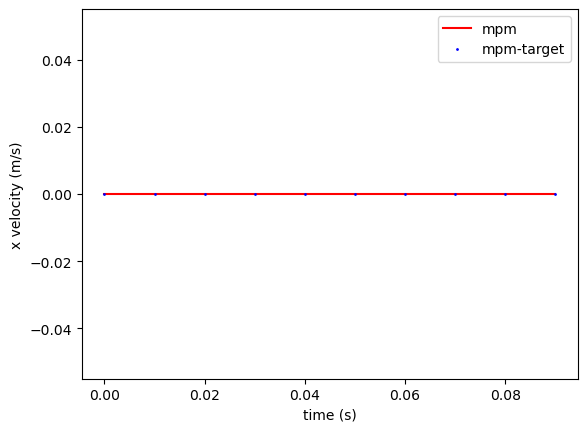

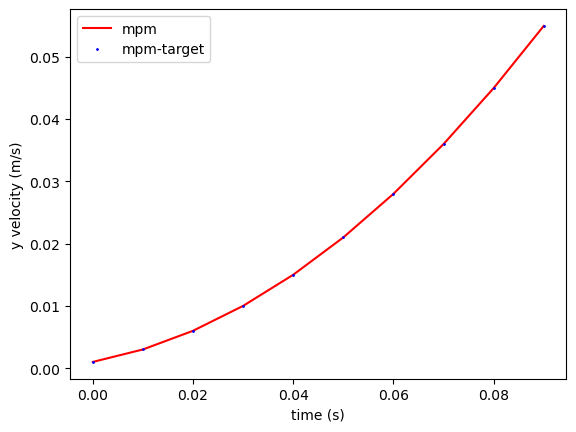

In [230]:
print("E: {}".format(result))
vel = mpm(result)
# update time steps
dt = 0.01
nsteps = 10
tt = jnp.arange(0, nsteps) * dt



# Plot results
plt.plot(tt, vel[:,0], 'r', markersize=1, label='mpm')
plt.plot(tt, target[:,0], 'ob', markersize=1, label='mpm-target')
plt.xlabel('time (s)')
plt.ylabel('x velocity (m/s)')
plt.legend()
plt.show()

plt.plot(tt, vel[:,1], 'r', markersize=1, label='mpm')
plt.plot(tt, target[:,1], 'ob', markersize=1, label='mpm-target')
plt.xlabel('time (s)')
plt.ylabel('y velocity (m/s)')
plt.legend()
plt.show()